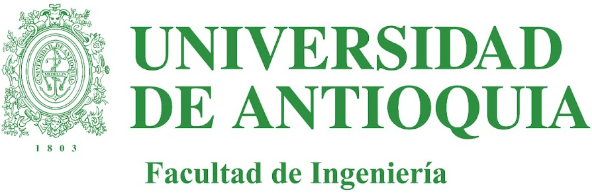

# **Análisis de Bio-señales para Computación Afectiva**
## Docente: Hernán Felipe García Arias
## Por: David Alexander Sánchez, Juan Pablo Areiza
### Universidad de Antioquia, Medellín 2023

## **Librerías**

In [1]:
!pip install peakutils #La biblioteca PeakUtils en Python proporciona utilidades relacionadas con la detección de picos en datos unidimensionales

In [2]:
import scipy.io as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import pandas as pd
import peakutils
from scipy.fft import fft, fftfreq

## **Dataset**

### Descripción

[DEAPdataset](https://www.eecs.qmul.ac.uk/mmv/datasets/deap/index.html) es una base de datos que contiene un conjunto de datos para el análisis de emociones utilizando señales de EEG, fisiológicas y de video. El dataset fue recopilado por el grupo de investigación Multimodal Interaction Lab en la Universidad Queen Mary de Londres. Contiene datos de 32 sujetos, cada uno expuesto a 40 clips de video cortos mientras se registraban sus señales fisiológicas y EEG. Los sujetos también proporcionaron calificaciones subjetivas de su experiencia emocional durante cada clip.

In [3]:
fs = 128 #En la descripción de los datos se informa que la frecuencia de muestreo es de 128 Hz

### Carga de datos

In [4]:
# s14: https://drive.google.com/file/d/1cNMil1P60z-XrqExnnKvmggmXWhI3glZ/view?usp=sharing
!gdown '1cNMil1P60z-XrqExnnKvmggmXWhI3glZ'
# s15: https://drive.google.com/file/d/1Fu3HL-cB64lTfuZS8iPhIfaJIsl1OszD/view?usp=sharing
!gdown '1Fu3HL-cB64lTfuZS8iPhIfaJIsl1OszD'
# s16: https://drive.google.com/file/d/1cBN0CYdrsUsVO77PyNq-Jkyh5pc0FI22/view?usp=sharing
!gdown '1cBN0CYdrsUsVO77PyNq-Jkyh5pc0FI22'
# s17: https://drive.google.com/file/d/1bMObQcIFrNalRmD1LaNuqVSTeqaeGqR3/view?usp=sharing
!gdown '1bMObQcIFrNalRmD1LaNuqVSTeqaeGqR3'

Downloading...
From: https://drive.google.com/uc?id=1cNMil1P60z-XrqExnnKvmggmXWhI3glZ
To: /content/s14.mat
100% 80.6M/80.6M [00:00<00:00, 117MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Fu3HL-cB64lTfuZS8iPhIfaJIsl1OszD
To: /content/s15.mat
100% 80.7M/80.7M [00:00<00:00, 171MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cBN0CYdrsUsVO77PyNq-Jkyh5pc0FI22
To: /content/s16.mat
100% 80.8M/80.8M [00:00<00:00, 221MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bMObQcIFrNalRmD1LaNuqVSTeqaeGqR3
To: /content/s17.mat
100% 80.7M/80.7M [00:00<00:00, 237MB/s]


In [5]:
#Carga de archivos .mat
datosP1 = sc.loadmat('s14.mat')
datosP2 = sc.loadmat('s15.mat')
datosP3 = sc.loadmat('s16.mat')
datosP4 = sc.loadmat('s17.mat')

In [6]:
signalsP1 = datosP1['data']
labelsP1 = datosP1['labels']

signalsP2 = datosP2['data']
labelsP2 = datosP2['labels']

signalsP3 = datosP3['data']
labelsP3 = datosP3['labels']

signalsP4 = datosP4['data']
labelsP4 = datosP4['labels']

In [7]:
signalsP1.shape

(40, 40, 6528)


Las variables signalPX, almacenan todas las reacciones emocionales derivadas de las señales biológicas para los 40 videos distintos.

## **Filtros**

In [ ]:
def filter(signal_input, f_order, f_cutoff, fs, filter_type):
    nyquist_freq = 0.5 * fs
    a = signal.butter(f_order, f_cutoff, btype=filter_type, analog=False, fs=fs, output='sos')
    filtered_signal = signal.sosfilt(a, signal_input)
    return filtered_signal


## **Descripción de señales**

1. **GSR (Galvanic Skin Response)**: También conocida como **Electrodermal Activity (EDA)** o **Skin Conductance (SC)**, la respuesta galvánica de la piel es una medida de la conductividad eléctrica de la piel. Se origina a partir de la activación autónoma de las glándulas sudoríparas en la piel. La GSR es sensible a la actividad simpática autónoma y se utiliza para evaluar el comportamiento emocional y el nivel de excitación [[1]](https://imotions.com/blog/learning/research-fundamentals/galvanic-skin-response/).

2. **Blood volume pressure**: Es una medida de la fuerza ejercida por la sangre contra las paredes de las arterias. La presión arterial se mide en milímetros de mercurio (mmHg) y se expresa en dos valores: presión sistólica (la presión cuando el corazón late) y presión diastólica (la presión cuando el corazón está en reposo entre latidos) [[2]](https://minds.wisconsin.edu/bitstream/handle/1793/80044/How%20do%20Physical%20responses%20such%20as%20respiratory%20frequency_heart%20rate_%20and%20galvanic%20skin%20response_GSR_change%20under%20emotional.pdf?sequence=1).

3. **Respiration pattern**: El patrón respiratorio se refiere a cómo una persona respira, incluyendo la frecuencia respiratoria, el ritmo y la profundidad de la respiración. Los patrones respiratorios normales varían según la edad, el estado físico y otros factores [[2]](https://minds.wisconsin.edu/bitstream/handle/1793/80044/How%20do%20Physical%20responses%20such%20as%20respiratory%20frequency_heart%20rate_%20and%20galvanic%20skin%20response_GSR_change%20under%20emotional.pdf?sequence=1).

4. **Skin temperature**: La temperatura de la piel se refiere a la temperatura de la cutánea. La temperatura cutánea puede variar según factores como el clima, la actividad física y las condiciones médicas. La temperatura cutánea se puede medir utilizando termómetros especiales o dispositivos portátiles [[2]](https://minds.wisconsin.edu/bitstream/handle/1793/80044/How%20do%20Physical%20responses%20such%20as%20respiratory%20frequency_heart%20rate_%20and%20galvanic%20skin%20response_GSR_change%20under%20emotional.pdf?sequence=1).

5. **EMG (Electromyography) y EOG (Electrooculography)**: El electromiograma (EMG) es una técnica que registra la actividad eléctrica de los músculos. La electrooculografía (EOG) registra los movimientos oculares mediante electrodos colocados alrededor de los ojos [[3]](https://www.sensortips.com/featured/what-is-the-difference-between-an-ecg-eeg-emg-and-eog/).

6. **EEG (Electroencephalography)**: La electroencefalografía es una técnica que registra la actividad eléctrica del cerebro mediante electrodos colocados en el cuero cabelludo [[3]](https://www.sensortips.com/featured/what-is-the-difference-between-an-ecg-eeg-emg-and-eog/).

## **Etiquetas emocionales**

**Excitación (arousal)**: El nivel de activación fisiológica o excitación experimentado en respuesta a un estímulo, que va desde bajo (tranquilo) hasta alto (intenso).

**Valencia (valence)**: La cualidad emocional o positividad/negatividad de la experiencia subjetiva de un individuo, que va desde negativa (desagradable) hasta positiva (agradable).

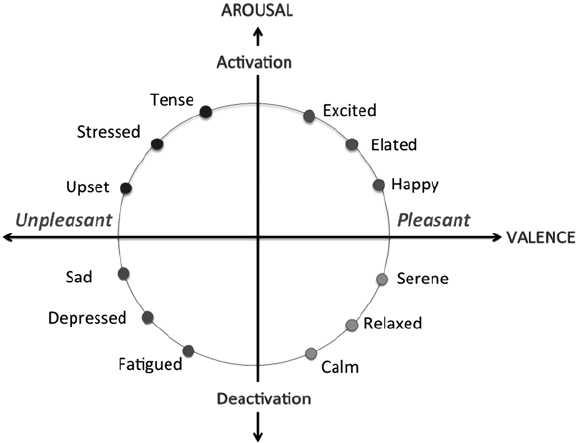


De acuerdo con el dataset, tanto Valence como Arousal son enteros entre 1 y 9, con base en esto, se realiza un grupamiento de las emociones en 3 grupos:

1. Arousal bajo o alto [1-3],[7-9] y Valence alto [7-9]: Puede etiquetarse como "Emoción Positiva".
2. Arousal bajo o alto [1-3],[7-9] y Valence bajo [1-3]: Puede etiquetarse como "Emoción Negativa".
3. Arousal y Valence que no cumpla los criterios anteriores: Puede etiquetarse como "Emoción Neutra"

In [ ]:
neg = 'Negativa'
neu = 'Neutra'
pos = 'Positiva'

valence = labelsP1[:, 0]
arousal = labelsP1[:, 1]

emociones = []

for i in range(40):
    if (arousal[i] <= 3 and valence[i] >= 7) or (arousal[i] >= 7 and valence[i] >= 7):
        emociones.append(pos)
    elif (arousal[i] <= 3 and valence[i] <= 3) or (arousal[i] >= 7 and valence[i] <= 3):
        emociones.append(neg)
    else:
        emociones.append(neu)

In [ ]:
# Se añaden las emociones en un dataframe
df = pd.DataFrame({'Emociones': emociones}, index=[f'Video {i+1}' for i in range(40)])

## **GSR**

Características:
- Average skin resistance
- Number of local minima in the GSR signal
- Average rising time of the GSR signal
- 10 Spectral power in the [0-2.4] Hz bands

In [ ]:
def gsr_features(gsr_signal, fs):
    # Average skin resistance
    avg_resistance = np.mean(gsr_signal)

    # Number of local minima in the GSR signal
    inverted_signal = -1 * gsr_signal
    indices_minima = peakutils.indexes(inverted_signal, thres=0.02/max(inverted_signal), min_dist=fs)
    num_minima = len(indices_minima)

    # Average rising time of the GSR signal
    indices_maxima = peakutils.indexes(gsr_signal, thres=0.02/max(gsr_signal), min_dist=fs)
    rise_times = []
    for i in range(len(indices_maxima)-1):
        rise_time = indices_maxima[i+1] - indices_maxima[i]
        rise_times.append(rise_time)
    avg_rise_time = np.mean(rise_times)

    # Spectral power in the [0-2.4] Hz bands
    filtered_signal = filter(gsr_signal,8,[0.0001,2.4],fs,"bandpass") #La frecuencia de corte 0.0001 se debe a que la frecuencia 0 Hz no está permitida
    yf = fft(filtered_signal)
    N = len(filtered_signal)
    T = 1./fs
    xf = fftfreq(N, T)[0:N//2]
    spectral_power = 2.0/N * np.abs(yf[0:N//2])
    # Ordenar las potencias espectrales en orden descendente
    sorted_indices = np.argsort(spectral_power)[::-1]

    # Obtener las 10 mayores potencias espectrales y sus correspondientes frecuencias
    top_spectral_power = spectral_power[sorted_indices[:10]]

    return avg_resistance, num_minima, avg_rise_time, top_spectral_power

In [ ]:
column_titles = ['GSR_Avg_Resistance', 'GSR_Num_Minima', 'GSR_Avg_Rise_Time']

# Creación de una lista para almacenar los DataFrames temporales de cada video
dfs = []

# Se itera a través de las señales GSR y extraer características
for video_index in range(40):
    gsr_signal = signalsP1[video_index, 36, :]
    avg_resistance, num_minima, avg_rise_time, spectral_power = gsr_features(gsr_signal, fs)  # Extraer características

    # Crear un DataFrame temporal para el video actual
    df_video = pd.DataFrame([[avg_resistance, num_minima, avg_rise_time] + list(spectral_power[:10])],
                            columns=column_titles + [f'GSR_Spectral_Power_{i+1}' for i in range(10)],
                            index=[f'Video {video_index+1}'])

    # Agregar el DataFrame temporal a la lista
    dfs.append(df_video)


# Concatenar todos los DataFrames temporales en uno solo
df_aux = pd.concat(dfs)

In [ ]:
df = df.join(df_aux) #Se une el dataframe que contiene los datos de las características de GSR con las emociones

## **Blood volume pressure**

Características:
- Average and standard deviation of HR
- Energy ratio between the frequency band [0.04-0.15]Hz
- Spectral power in the band [0.1-0.2]Hz


In [ ]:
def bvp_features(blv_signal, fs):
    # Average and standard deviation of HR (Heart Rate)
    hr = 60 / np.diff(np.where(blv_signal > np.mean(blv_signal)))[0]  # Estimación de la frecuencia cardíaca por minuto
    avg_hr = np.mean(hr)
    std_hr = np.std(hr)

    # Energy ratio between the frequency band [0.04-0.15]Hz
    filtered_signal = filter(blv_signal,8,[0.04,0.15],fs,"bandpass")
    energy_band = np.sum(filtered_signal ** 2)
    total_energy = np.sum(blv_signal ** 2)
    energy_ratio = energy_band / total_energy

    # Spectral power in the band [0.1-0.2]Hz
    filtered_signal = filter(blv_signal,8,[0.1,0.2],fs,"bandpass")
    yf = fft(filtered_signal)
    N = len(filtered_signal)
    T = 1./fs
    spectral_power = 2.0/N * np.abs(yf[0:N//2])
    spectral_power = np.sum(spectral_power)

    return avg_hr, std_hr, energy_ratio, spectral_power

In [ ]:
column_titles = ['BVP_Avg_HR', 'BVP_Std_HR', 'BVP_Energy_Ratio', 'BVP_Spectral_Power']

# Creación de una lista para almacenar los DataFrames temporales de cada video
dfs = []

# Se itera a través de las señales BVP y extraer características
for video_index in range(40):
    bvp_signal = signalsP1[video_index, 38, :]
    avg_hr, std_hr, energy_ratio, spectral_power = bvp_features(bvp_signal, fs)  # Extraer características

    # Crear un DataFrame temporal para el video actual
    df_video = pd.DataFrame([[avg_hr, std_hr, energy_ratio, spectral_power]],
                            columns=column_titles,
                            index=[f'Video {video_index+1}'])

    # Agregar el DataFrame temporal a la lista
    dfs.append(df_video)


# Concatenar todos los DataFrames temporales en uno solo
df_aux = pd.concat(dfs)

In [ ]:
df = df.join(df_aux)

## **Respiration pattern**

Características:
- Average respiration signal
- Standard deviation
- Breathing rate

In [ ]:
def rp_features(rp_signal, fs):
    # Average respiration signal
    avg_rp_signal = np.mean(rp_signal)

    # Standard deviation
    std_dev = np.std(rp_signal)

    # Breathing rate
    peaks = peakutils.indexes(rp_signal, thres=0.02/max(rp_signal), min_dist=3.3*fs) #Considerando un promedio de 15 respiraciones por minuto y teniendo en cuenta que los vídeos son de alrededor de 50 segundos, se establece una distancia mínima entre picos
    time_between_peaks = np.diff(peaks) / fs  # En segundos

    # Calcular la frecuencia respiratoria en ciclos por minuto (BPM)
    breathing_rate = 60 / np.mean(time_between_peaks)

    return avg_rp_signal, std_dev, breathing_rate

In [ ]:
column_titles = ['RP_Avg_Respiration', 'RP_Std_Respiration', 'RP_Breathing_Rate']

# Creación de una lista para almacenar los DataFrames temporales de cada video
dfs = []

# Se itera a través de las señales BVP y extraer características
for video_index in range(40):
    rp_signal = signalsP1[video_index, 37, :]
    avg_rp_signal, std_dev, breathing_rate = rp_features(rp_signal, fs)  # Extraer características

    # Crear un DataFrame temporal para el video actual
    df_video = pd.DataFrame([[avg_rp_signal, std_dev, breathing_rate]],
                            columns=column_titles,
                            index=[f'Video {video_index+1}'])

    # Agregar el DataFrame temporal a la lista
    dfs.append(df_video)


# Concatenar todos los DataFrames temporales en uno solo
df_aux = pd.concat(dfs)

In [ ]:
df = df.join(df_aux)

## **Skin temperature**

Características:
- Average Skin Temperature
- Average of its derivative
- Spectral power in the bands ([0.1-0.2]Hz

In [ ]:
def st_features(st_signal, fs):
    # Average Skin Temperature
    avg_st_signal = np.mean(st_signal)

    # Average of its derivative
    st_derivative = np.gradient(st_signal)
    avg_derivative = np.mean(st_derivative)

    # Spectral power in the band [0.1-0.2]Hz
    filtered_signal = filter(st_signal,8,[0.00001,0.2],fs,"bandpass")

    # Calculate the spectral power in the filtered signal
    yf = fft(filtered_signal)
    N = len(filtered_signal)
    spectral_power = 2.0/N * np.abs(yf[0:N//2])
    spectral_power = np.sum(spectral_power)


    return avg_st_signal, avg_derivative, spectral_power

In [ ]:
# Definir los títulos de las columnas
column_titles = ['ST_Avg_Skin_Temperature', 'ST_Avg_Derivative', 'ST_Spectral_Power_0-0.1Hz']

# Creación de una lista para almacenar los DataFrames temporales de cada video
dfs = []

# Se itera a través de los videos y se extraen características de la señal de temperatura de la piel
for video_index in range(40):
    st_signal = signalsP1[video_index,39,:]  # Reemplaza esto con tu señal de temperatura de la piel
    avg_st_signal, avg_derivative, spectral_power_band = st_features(st_signal,fs)  # Extraer características

    # Crear un DataFrame temporal para el video actual
    df_video = pd.DataFrame([[avg_st_signal, avg_derivative, spectral_power_band]],
                            columns=column_titles,
                            index=[f'Video {video_index+1}'])

    # Agregar el DataFrame temporal a la lista
    dfs.append(df_video)

# Concatenar todos los DataFrames temporales en uno solo
df_aux = pd.concat(dfs)

TypeError: ignored

## **zEMG**

Características:
- energy of the signal
- mean of the signal
- variance of the signal

In [ ]:
def zEMG_features(zEMG_signal, fs):
    # Calculate energy of the signal
    energy = np.sum(np.abs(zEMG_signal)**2)

    # Calculate mean of the signal
    mean = np.nanmean(zEMG_signal)

    # Calculate variance of the signal
    variance = np.var(zEMG_signal)

    return energy, mean, variance


In [ ]:

column_titles = ['zEMG_Energy', 'zEMG_Mean', 'zEMG_Variance']

# Create a list to store temporary DataFrames for each video
dfs = []

# Iterate through the videos and extract features from the zEMG signal
for video_index in range(40):
    zEMG_signal = signalsP1[video_index, 35-1, :]  # Replace with your actual zEMG signal
    energy, mean, variance = zEMG_features(zEMG_signal, fs)  # Extract features

    # Create a temporary DataFrame for the current video
    df_video = pd.DataFrame([[energy, mean, variance]],
                            columns=column_titles,
                            index=[f'Video {video_index+1}'])

    # Add the temporary DataFrame to the list
    dfs.append(df_video)

# Concatenate all the temporary DataFrames into one
df_aux = pd.concat(dfs)


## **tEMG**

Características:
- energy of the signal
- mean of the signal
- variance of the signal

In [ ]:
def tEMG_features(tEMG_signal, fs):
    # Calculate energy of the signal
    energy = np.sum(np.abs(tEMG_signal)**2)

    # Calculate mean of the signal
    mean = np.nanmean(tEMG_signal)

    # Calculate variance of the signal
    variance = np.var(tEMG_signal)

    return energy, mean, variance

In [ ]:
column_titles = ['tEMG_Energy', 'tEMG_Mean', 'tEMG_Variance']

# Create a list to store temporary DataFrames for each video
dfs = []

# Iterate through the videos and extract features from the zEMG signal
for video_index in range(40):
    zEMG_signal = signalsP1[video_index, 35, :]  # Replace with your actual zEMG signal
    energy, mean, variance = zEMG_features(zEMG_signal, fs)  # Extract features

    # Create a temporary DataFrame for the current video
    df_video = pd.DataFrame([[energy, mean, variance]],
                            columns=column_titles,
                            index=[f'Video {video_index+1}'])

    # Add the temporary DataFrame to the list
    dfs.append(df_video)

# Concatenate all the temporary DataFrames into one
df_aux = pd.concat(dfs)


## **EEG**
caracteristicas:
- Spectral power T7 Beta band $[14-30]Hz$
- Spectral power T8 Beta band $[14-30]Hz$
- The spectral power asymmetry Beta band $[14-30]Hz$

In [8]:
def eeg_features(eeg_signal, fs):
    # Define frequency bands
    bands = [[14, 30]]  # Beta band [14-30]Hz

    # Initialize lists to store spectral power for T7 and T8
    spectral_power_t7 = []
    spectral_power_t8 = []
    spectral_power_asymmetry = []

    for band in bands:
        # Calculate spectral power for T7
        signal_t7_filtered = butter_bandpass_filter(eeg_signal, band[0], band[1], fs)
        f_t7, Pxx_t7 = welch(signal_t7_filtered, fs, nperseg=1024)
        spectral_power_t7.append(np.max(Pxx_t7))

        # Calculate spectral power for T8
        signal_t8_filtered = butter_bandpass_filter(eeg_signal, band[0], band[1], fs)
        f_t8, Pxx_t8 = welch(signal_t8_filtered, fs, nperseg=1024)
        spectral_power_t8.append(np.max(Pxx_t8))

        # Calculate spectral power asymmetry
        signal_asymmetry = signal_t7_filtered - signal_t8_filtered
        f_asymmetry, Pxx_asymmetry = welch(signal_asymmetry, fs, nperseg=1024)
        spectral_power_asymmetry.append(np.max(Pxx_asymmetry))

    spectral_power_t7 = np.array(spectral_power_t7)
    spectral_power_t8 = np.array(spectral_power_t8)
    spectral_power_asymmetry = np.array(spectral_power_asymmetry)

    return spectral_power_t7, spectral_power_t8, spectral_power_asymmetry








## **Visualización de datos**

In [ ]:
df

,Emociones,GSR_Avg_Resistance,GSR_Num_Minima,GSR_Avg_Rise_Time,GSR_Spectral_Power_1,GSR_Spectral_Power_2,GSR_Spectral_Power_3,GSR_Spectral_Power_4,GSR_Spectral_Power_5,GSR_Spectral_Power_6,...,GSR_Spectral_Power_8,GSR_Spectral_Power_9,GSR_Spectral_Power_10,BVP_Avg_HR,BVP_Std_HR,BVP_Energy_Ratio,BVP_Spectral_Power,RP_Avg_Respiration,RP_Std_Respiration,RP_Breathing_Rate
Video 1,Positiva,-18005.683435,13,410.461538,33405.444773,12415.736592,10698.074852,5155.897038,3874.836546,3503.587486,...,3010.240760,2483.330703,2382.528759,59.883513,2.618971,0.142911,14814.620476,1236.911337,2111.553904,12.441277
Video 2,Neutra,-8794.650746,15,350.117647,16293.422095,9325.021496,5975.311454,2949.566499,1935.672059,1845.186864,...,974.837702,938.945941,900.433328,59.740820,3.828476,0.172499,9591.928697,-820.366672,950.633392,12.337349
Video 3,Neutra,-1331.408630,18,336.222222,3182.753201,2389.673359,980.841268,448.734194,360.344443,279.304636,...,229.224006,217.936368,208.449839,59.867192,2.661189,0.218002,5102.319175,-2707.540953,845.743322,14.598448
Video 4,Neutra,3491.283824,15,346.750000,6450.935589,4203.907937,1904.715558,1479.992938,1134.924769,914.080432,...,664.378771,367.873687,247.731055,59.815781,3.291930,0.233086,13261.823556,252.170543,1324.310393,14.299457
Video 5,Neutra,-3736.386024,23,258.833333,6978.202980,3847.452251,1573.085329,1374.493839,1294.347548,1225.965253,...,868.306058,835.965634,687.860006,59.721944,4.020158,0.024882,7342.591757,-1270.623131,902.863884,14.355140
Video 6,Neutra,-848.909184,17,375.764706,4486.181129,1985.445479,1752.872762,1198.571632,1061.370592,899.509698,...,530.219099,324.993263,315.578619,59.809094,3.344834,0.311322,5930.733892,-896.817617,644.788510,15.019557
Video 7,Neutra,-8999.583679,14,408.666667,16682.119116,5281.211668,4710.258120,2226.435443,1789.782908,1376.116691,...,892.633971,828.212384,755.781933,59.898419,2.429150,0.088823,5465.960832,-1034.814245,660.768799,13.945196
Video 8,Neutra,-517.923350,16,357.176471,3683.795511,1984.365301,1830.854124,805.107916,762.679028,699.233138,...,643.838580,472.947422,393.654591,59.728404,3.953753,0.019958,18791.038593,-595.614598,493.131265,14.659032
Video 9,Positiva,-9165.069658,11,440.307692,17116.423378,5468.787463,4656.387315,3418.487208,1769.369127,1587.434273,...,1102.209064,796.305043,740.653399,59.919988,2.172789,0.191234,15715.209793,-1674.661787,911.825694,15.312883
Video 10,Negativa,5519.865947,21,301.333333,10275.785337,2594.777684,2245.267133,1475.749870,1056.001069,699.515450,...,445.340544,429.887209,383.280693,59.440775,5.665837,0.118730,13762.633907,-1898.667778,599.589659,15.317582


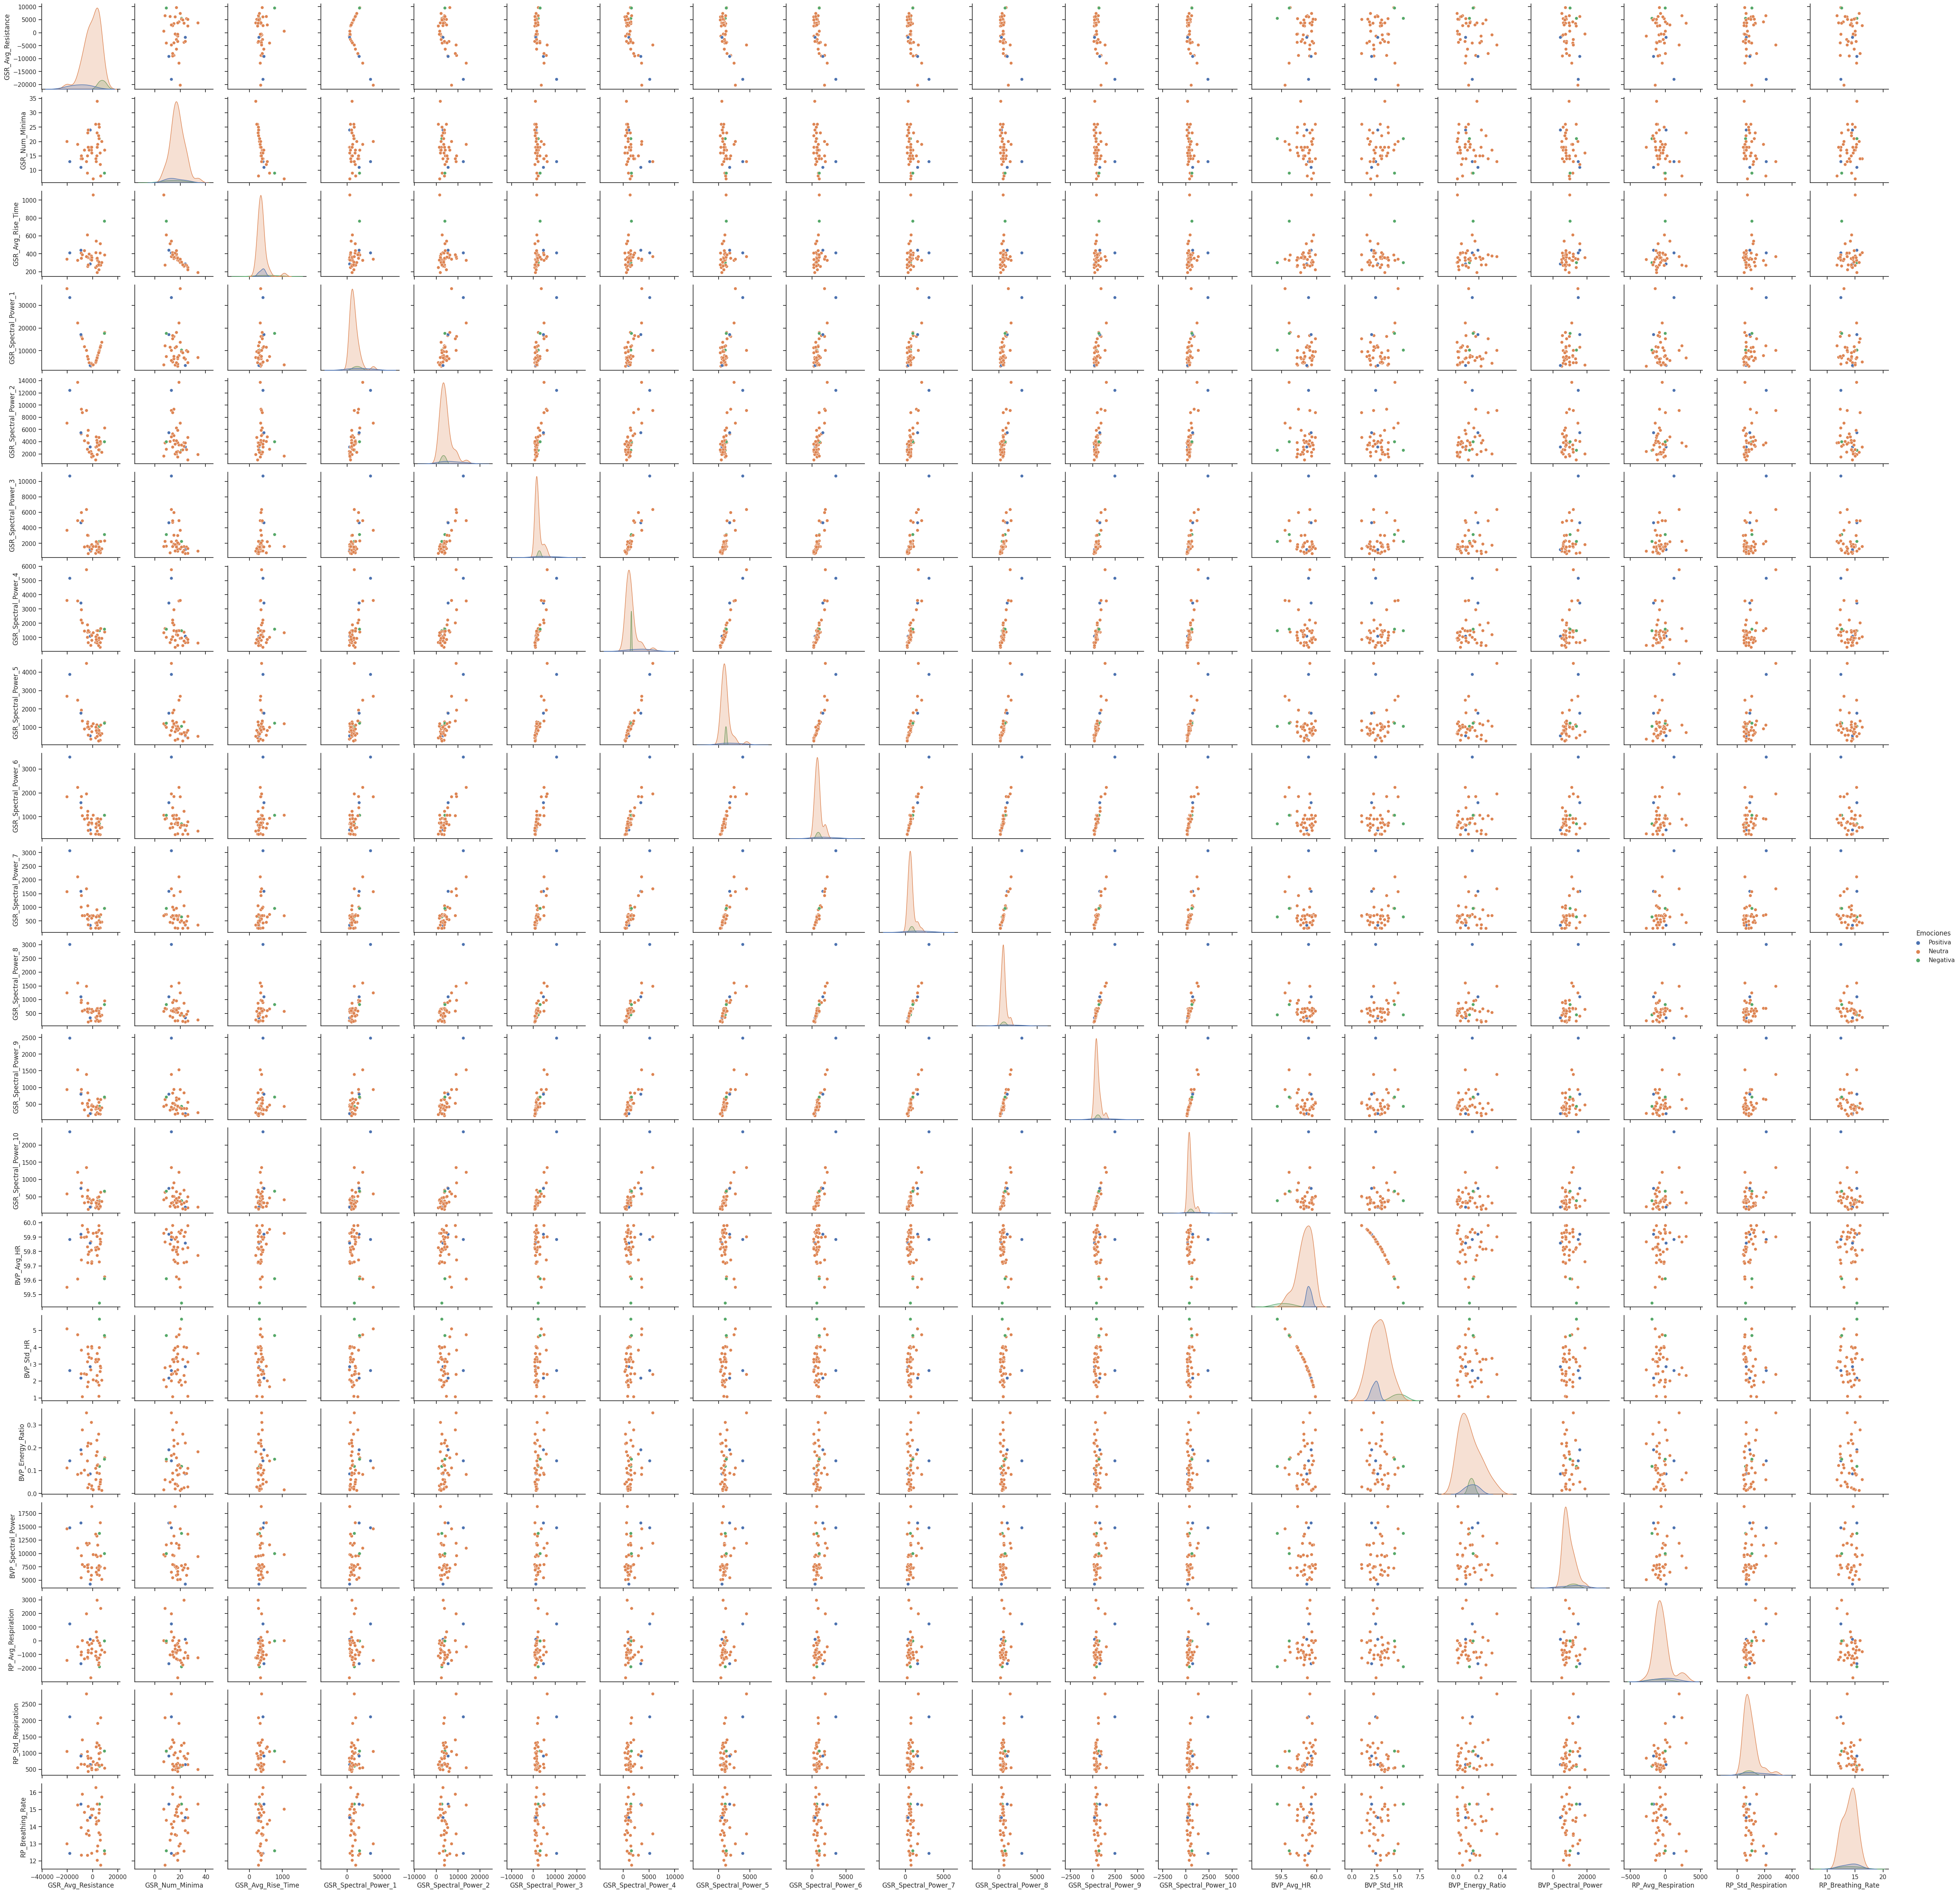

In [ ]:
sns.set(style="ticks")
sns.pairplot(df,hue="Emociones")

# Mostrar el gráfico
plt.show()

## **Referencias**

1. Galvanic Skin Response (GSR): The Complete Pocket Guide. https://imotions.com/blog/learning/research-fundamentals/galvanic-skin-response/.
2. How do physiological responses such as respiratory frequency, heart .... https://minds.wisconsin.edu/bitstream/handle/1793/80044/How%20do%20Physical%20responses%20such%20as%20respiratory%20frequency_heart%20rate_%20and%20galvanic%20skin%20response_GSR_change%20under%20emotional.pdf?sequence=1.
3. What is the difference between an ECG, EEG, EMG and EOG? - Sensor Tips. https://www.sensortips.com/featured/what-is-the-difference-between-an-ecg-eeg-emg-and-eog/.
4. PeakUtils · PyPI. https://pypi.org/project/PeakUtils/.